In [0]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
pip install scikit-surprise

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import KNNWithMeans
from surprise import accuracy
from surprise.model_selection import train_test_split
import datetime

In [0]:
data_frame = pd.read_csv('/content/drive/My Drive/ratings_Electronics.csv')

In [7]:
data_frame.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [0]:
#the data does not have headers let us add them from the project description
data_frame.columns = ["userid", "productid", "rating", "timestamp"]

In [9]:
data_frame.head()

,userid,productid,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


the data has four columns

In [10]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
userid       object
productid    object
rating       float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


we have a huge data set with more than 78 lakhs records.Let us check for null values.

In [11]:
data_frame.isnull().sum()

userid       0
productid    0
rating       0
timestamp    0
dtype: int64

There are no null records.

In [12]:
data_frame.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,7824481.0,4.012337e+00,1.380910e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,7824481.0,1.338178e+09,6.900426e+07,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


It looks logical that the rating is from 1 to 5.
More than 50 percent of data has 5 rating.
It may be because the products are good otherwise there is some kind of bias in the data which need to be removed.

In [0]:
# convert unix date to raw date format
data_frame['date'] = pd.to_datetime(data_frame['timestamp'],unit='s')

In [14]:
data_frame.head()

,userid,productid,rating,timestamp,date
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800,2012-07-01
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600,2013-04-29
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200,2013-07-22
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200,2012-04-18
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600,2014-04-14


In [15]:
data_frame.date.min()

Timestamp('1998-12-04 00:00:00')

In [16]:
data_frame.date.max()

Timestamp('2014-07-23 00:00:00')

we have data from 04 dec 98 to 23 Aug 2014

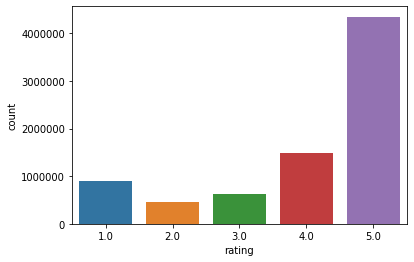

In [17]:
#Let us check the distribution of ratings
sns.countplot(data_frame.rating)

**Observations**

Maximum number of users have given a rating of 5.The users who have been 
happy with the product might have given 5 without much thought process.The rating may not be true reflection of the product quality.

Also many users have 4 rating.This rating looks more reliable compared to 1 or 5.

The customers who had even simple disappointment with product might have given 1.Like the rating5, rating1 is also not completely reliable.

we need to remove this bias while modeling the recommender system.



In [18]:
data_frame.nunique()

userid       4201696
productid     476001
rating             5
timestamp       5489
date            5489
dtype: int64

we can see that out of 78 lakh records

*  There are 42 lakh customers, which means there are repeated customers
*  There are 4 lakh 76 thousand products, so the products are repeated multiple times.on an average 15 times.

*   The timestamp is 5489 which means may recordings are taken on the same date.we have nearly 16 years record. 5840 (16 * 365) days. so the data looks logical





In [19]:
#let us see the top 5 products with maximum number of ratings..This would come under popularity based system.
data_frame.productid.value_counts()[:5]

B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
Name: productid, dtype: int64

These are the five products many reviewers have given reviews.

In [20]:
#let us see how the number of reviews over time.
#grouping the year and month
data_frame_date_parsed = data_frame.copy() 
data_frame_date_parsed['year'] = data_frame_date_parsed['date'].apply(lambda x: "%d" % (x.year))
data_frame_date_parsed['month'] = data_frame_date_parsed['date'].apply(lambda x: "%d" % (x.month))
data_frame_date_parsed.head()

,userid,productid,rating,timestamp,date,year,month
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800,2012-07-01,2012,7
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600,2013-04-29,2013,4
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200,2013-07-22,2013,7
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200,2012-04-18,2012,4
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600,2014-04-14,2014,4


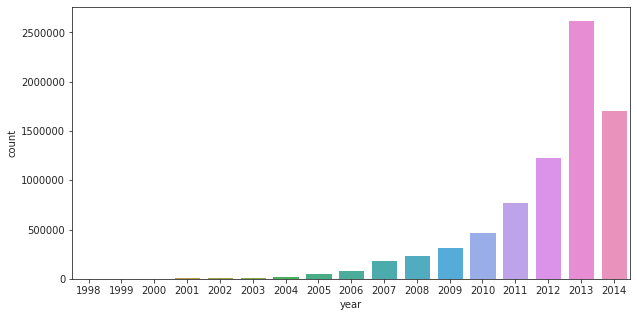

In [21]:
sns.set_style('ticks')
fig, ax = plt.subplots()

fig.set_size_inches(10, 5)
sns.countplot(data_frame_date_parsed.year)


we can clearly see that the number of users increased over time.

Only exception -> The 2014 records are less compared to 2013.This looks reasonable as we have record only till august month in 2014 whereas we have data for whole year for 2013.

overall we can see that the number of reviewers are increasing multifold every year signifying the business development.

we have to check if the products that were recommended in 1998 is still recommeded in 2014.

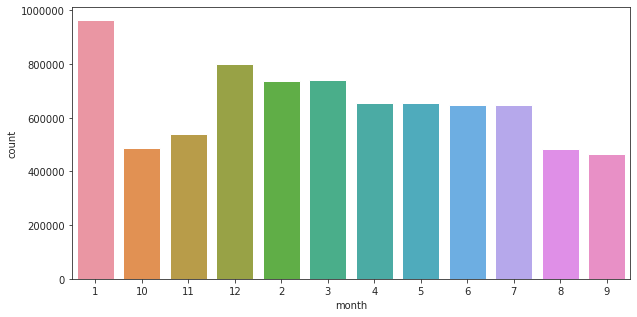

In [22]:
sns.set_style('ticks')
fig, ax = plt.subplots()

fig.set_size_inches(10, 5)
sns.countplot(data_frame_date_parsed.month)

we can see that the number of reviews vary per month.During January and December the reviews are greater.
watching closer, the reviews are greater in number during december to March.
we can assume that the sales is greater in the last quarter of the fiscal year

# Popularity based recommendation system

**Popularity based recommendation system - highest total rating**

In [23]:
#Let us create a recommendation system with overall highest total ratings
print("Five products with highest overall Rating")
data_frame.groupby('productid')['rating'].sum().sort_values(ascending = False).head()

Five products with highest overall Rating


productid
B0074BW614    81943.0
B00DR0PDNE    64681.0
B007WTAJTO    62697.0
B0019EHU8G    58409.0
B006GWO5WK    52751.0
Name: rating, dtype: float64

Above shown are the products with highest rating in total.In this list we may have products which may have got 1 star rating. but still reviewed by many people.

**Popularity based recommendation system - highest Average rating**

In [24]:
#Let us create a recommendation system with overall highest average ratings

print("Five products with highest average Rating")
data_frame.groupby('productid')['rating'].mean().sort_values(ascending = False).head()

Five products with highest average Rating


productid
BT008V9J9U    5.0
B0058PRC0S    5.0
B0058ORBFU    5.0
B0058OQ9Q2    5.0
B0058OKSMS    5.0
Name: rating, dtype: float64

**Popularity based recommendation system - highest weighted average rating**

The weigheted average rating is done to 

"*This formula is employed to prevent extreme votes from skewing the data and providing an inaccurate result.*"
-http://trailerpark.weebly.com/imdb-rating.html

In [25]:
data_frame_voting_count = data_frame_date_parsed.copy()
data_frame_voting_count['vote_count'] = data_frame.groupby('productid')['productid'].transform('count')
data_frame_voting_count['vote_average'] = data_frame.groupby('productid')['rating'].transform('mean')
data_frame_voting_count.head()

,userid,productid,rating,timestamp,date,year,month,vote_count,vote_average
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800,2012-07-01,2012,7,1,5.000000
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600,2013-04-29,2013,4,3,1.666667
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200,2013-07-22,2013,7,3,1.666667
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200,2012-04-18,2012,4,3,1.666667
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600,2014-04-14,2014,4,6,4.500000


In [26]:
V = data_frame_voting_count['vote_count']
R = data_frame_voting_count['vote_average']
C = data_frame_voting_count['vote_average'].mean()
m = data_frame_voting_count['vote_count'].quantile(0.70) # taking the ratings with more than 70 percentile

data_frame_voting_count['weighted_average'] = (V/(V+m) * R) + (m/(m+V) * C)
data_frame_voting_count.head()

,userid,productid,rating,timestamp,date,year,month,vote_count,vote_average,weighted_average
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800,2012-07-01,2012,7,1,5.000000,4.014527
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600,2013-04-29,2013,4,3,1.666667,3.996802
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200,2013-07-22,2013,7,3,1.666667,3.996802
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200,2012-04-18,2012,4,3,1.666667,3.996802
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600,2014-04-14,2014,4,6,4.500000,4.018753


In [27]:
 print("Top 5 popular products with highest average rating devoid of bias")
 data_frame_voting_count.sort_values('weighted_average', ascending=False).head()

Top 5 popular products with highest average rating devoid of bias


,userid,productid,rating,timestamp,date,year,month,vote_count,vote_average,weighted_average
3853677,AOCR9PQ1ABZFT,B0043WJRRS,5.0,1344556800,2012-08-10,2012,8,2512,4.881369,4.749342
3852829,A2QJ60EAJQJRNY,B0043WJRRS,5.0,1347148800,2012-09-09,2012,9,2512,4.881369,4.749342
3853474,A2K0EWVU7PYHHT,B0043WJRRS,5.0,1403222400,2014-06-20,2014,6,2512,4.881369,4.749342
3853475,AR8BBUCXANE5L,B0043WJRRS,5.0,1402185600,2014-06-08,2014,6,2512,4.881369,4.749342
3852848,A3CV4X7OORVJOQ,B0043WJRRS,5.0,1398038400,2014-04-21,2014,4,2512,4.881369,4.749342


It looks like all the five products are the same.Let us group the products to get the top 5 products

In [28]:
data_frame_voting_count.groupby('productid')['weighted_average'].mean().sort_values(ascending = False).head()

productid
B0043WJRRS    4.749342
B0019EHU8G    4.728273
B000LRMS66    4.720082
B003FVVMS0    4.690693
B0052SCU8U    4.689199
Name: weighted_average, dtype: float64

**Popularity based recommendation system - Monthly basis - highest weighted average rating**

In [29]:
grouped_by_month = data_frame_voting_count.groupby(data_frame_date_parsed["month"])
for key_value in grouped_by_month.groups.keys():
  print("Top 5 popular products for the month",key_value)
  month_data = pd.DataFrame(grouped_by_month.get_group(key_value))
  print(month_data.groupby('productid')['weighted_average'].mean().sort_values(ascending = False).head())


Top 5 popular products for the month 1
productid
B0043WJRRS    4.749342
B0019EHU8G    4.728273
B000LRMS66    4.720082
B003FVVMS0    4.690693
B0052SCU8U    4.689199
Name: weighted_average, dtype: float64
Top 5 popular products for the month 10
productid
B0043WJRRS    4.749342
B0019EHU8G    4.728273
B000LRMS66    4.720082
B003FVVMS0    4.690693
B0052SCU8U    4.689199
Name: weighted_average, dtype: float64
Top 5 popular products for the month 11
productid
B0043WJRRS    4.749342
B0019EHU8G    4.728273
B000LRMS66    4.720082
B003FVVMS0    4.690693
B0052SCU8U    4.689199
Name: weighted_average, dtype: float64
Top 5 popular products for the month 12
productid
B0043WJRRS    4.749342
B0019EHU8G    4.728273
B000LRMS66    4.720082
B003FVVMS0    4.690693
B0052SCU8U    4.689199
Name: weighted_average, dtype: float64
Top 5 popular products for the month 2
productid
B0043WJRRS    4.749342
B0019EHU8G    4.728273
B000LRMS66    4.720082
B003FVVMS0    4.690693
B0052SCU8U    4.689199
Name: weighted_averag

It is  clearly visible that the famous products are consistent across all the months

# Matrix factorization

In [30]:
#Let us do some data wrangling before going for colabortive recommendation
data_frame_filtered = data_frame_voting_count.copy()
#taking into accunt only those products which have more than 100 reviewer ratings
data_frame_filtered = data_frame_voting_count[data_frame_voting_count["vote_count"] > 1000]
data_frame_filtered.shape

(1377717, 10)

In [36]:
grouped_by_month_filtered = data_frame_filtered.groupby(data_frame_filtered["month"])
month_data_Jan = pd.DataFrame(grouped_by_month_filtered.get_group('1'))
month_data_Jan = month_data_Jan[month_data_Jan['date']>pd.Timestamp(2000,1,1)] 
month_data_Jan = month_data_Jan.head(5000)
month_data_Jan.shape

(5000, 10)

In [0]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(month_data_Jan[['userid', 'productid', 'rating']], reader)

In [0]:
trainset = data.build_full_trainset()

In [39]:
trainset

In [40]:
trainset.ur

defaultdict(list,
            {0: [(0, 5.0)],
             1: [(0, 1.0)],
             2: [(0, 5.0)],
             3: [(0, 4.0)],
             4: [(0, 4.0)],
             5: [(0, 5.0)],
             6: [(0, 5.0)],
             7: [(0, 5.0)],
             8: [(0, 4.0)],
             9: [(0, 5.0)],
             10: [(0, 4.0)],
             11: [(0, 4.0)],
             12: [(0, 5.0)],
             13: [(0, 5.0)],
             14: [(0, 5.0)],
             15: [(0, 5.0)],
             16: [(0, 5.0)],
             17: [(0, 5.0)],
             18: [(0, 5.0)],
             19: [(0, 5.0)],
             20: [(0, 5.0)],
             21: [(0, 5.0)],
             22: [(0, 5.0)],
             23: [(0, 5.0)],
             24: [(0, 5.0)],
             25: [(0, 5.0)],
             26: [(0, 5.0)],
             27: [(0, 4.0)],
             28: [(0, 4.0)],
             29: [(0, 4.0)],
             30: [(0, 5.0)],
             31: [(0, 5.0)],
             32: [(0, 5.0)],
             33: [(0, 5.0)],
      

In [41]:
algo = SVD()
algo.fit(trainset)

In [0]:
testset = trainset.build_anti_testset()

In [0]:
predictions = algo.test(testset)

In [45]:
predictions

[Prediction(uid='A17S5ODXALEGVP', iid='B00001P4ZH', r_ui=4.2382, est=4.324604122544916, details={'was_impossible': False}),
 Prediction(uid='A17S5ODXALEGVP', iid='B00001WRSJ', r_ui=4.2382, est=4.561539011001854, details={'was_impossible': False}),
 Prediction(uid='A17S5ODXALEGVP', iid='B00004SABB', r_ui=4.2382, est=4.368070784484391, details={'was_impossible': False}),
 Prediction(uid='A17S5ODXALEGVP', iid='B00004SB92', r_ui=4.2382, est=3.8701599217680367, details={'was_impossible': False}),
 Prediction(uid='A17S5ODXALEGVP', iid='B00004T8R2', r_ui=4.2382, est=4.3937322098032165, details={'was_impossible': False}),
 Prediction(uid='A17S5ODXALEGVP', iid='B00004ZCJE', r_ui=4.2382, est=4.072286349759953, details={'was_impossible': False}),
 Prediction(uid='A17S5ODXALEGVP', iid='B00005ATMB', r_ui=4.2382, est=4.637431717605928, details={'was_impossible': False}),
 Prediction(uid='A17S5ODXALEGVP', iid='B00005LEN4', r_ui=4.2382, est=4.520812245029382, details={'was_impossible': False}),
 Predi

In [0]:
def give_top_recommendation(userID,myList,n):
  userItems = [x for x in myList if x.uid == userID]
  userItems.sort(key=lambda x: x.est, reverse=True)
  print(" top 5 recommendations for the user ",userID )
  for i in range(n):
    print(userItems[i].iid)

In [70]:
give_top_recommendation("A17S5ODXALEGVP",predictions,5)

 top 5 recommendations for the user  A17S5ODXALEGVP
B00007E7JU
B000062VUO
B00005ATMB
B00009R6TA
B000065BPB


# User-User Collaborative filtering

In [0]:
train_set, test_set = train_test_split(data, test_size=.30)

In [47]:
algo = KNNWithMeans(k=10, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(train_set)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [0]:
test_pred = algo.test(test_set)

In [54]:
test_pred

[Prediction(uid='A2GSWLUSD8OACZ', iid='B00005T3G0', r_ui=5.0, est=4.234857142857143, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2EMJOJ4H9CRS0', iid='B000065BPB', r_ui=5.0, est=4.234857142857143, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1F18I5W4XZKB7', iid='B000062VUO', r_ui=5.0, est=4.234857142857143, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A38E8E0DQ87UUV', iid='B00005N6KG', r_ui=2.0, est=4.234857142857143, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3OZCQAVS7NGUN', iid='B000065BP9', r_ui=5.0, est=4.234857142857143, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='ADF86HAB3K6EF', iid='B000089GN3', r_ui=1.0, est=4.234857142857143, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1MXQZLG2TBMCI', i

In [50]:
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.2245


1.2245271618335083

In [73]:
give_top_recommendation("A2GSWLUSD8OACZ",test_pred,1)

 top 5 recommendations for the user  A2GSWLUSD8OACZ
B00005T3G0


# Item based Collaborative filtering

In [51]:
algo = KNNWithMeans(k=10, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(train_set)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [0]:
test_pred_item_based = algo.test(test_set)

In [53]:
print("Item-based Model : Test Set")
accuracy.rmse(test_pred_item_based, verbose=True)

Item-based Model : Test Set
RMSE: 1.2189


1.2188687881391884

In [0]:
give_top_recommendation("A2GSWLUSD8OACZ",test_pred_item_based,1)

# Summary



*   The major challenge was handling the huge amount of data
*   Though we had huge amount of data, we worked only 5000 records because of infrastructure problem

*   but we were able to make the sample with logical ideas like splitting based on month and number of ratings
*   implemented popularity based, collaborative filtering and matrix factorization techniques



